## Installations, Imports, Plotting Utils

In [ ]:
!pip -qqq install wandb

In [4]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
import numpy as np
wandb.login(key="76fdad476f01ca03a4b43a03616920f905a25488")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

wandb: Currently logged in as: mariyamuneeb (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/mujahid/.netrc


# Model Design

## Encoder Class

In [12]:
class VariationalEncoder(nn.Module):
    def __init__(self, num_input_channels,
                 base_channel_size,
                 latent_dims,
                 ):
        super(VariationalEncoder, self).__init__()
        c_hid = base_channel_size
        self.conv1 = nn.Conv2d(num_input_channels, c_hid, kernel_size = 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(c_hid, 2*c_hid,  kernel_size =3, stride=2, padding=1)
        # self.batch2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(2*c_hid, 2*2*c_hid, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(2*2*c_hid, 2*2*2*c_hid, kernel_size=3, stride=2,padding=1)
        self.conv5 = nn.Conv2d(2*2*2*c_hid, 2*2*2*2*c_hid, kernel_size=3, padding=1, stride=2)
        self.linear1 = nn.Linear(4*4*16*c_hid, 4*2*c_hid)
        self.linear2 = nn.Linear(4*2*c_hid, latent_dims)
        self.linear3 = nn.Linear(4*2*c_hid, latent_dims)
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc # hack to get sampling on the GPU
        self.N.scale = self.N.scale
        self.kl = 0

    def forward(self, x):        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.flatten(x,start_dim=1)
        x = self.linear1(x)
        x = F.relu(x)
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
        # return x

In [ ]:
x = torch.rand(8,1,128,128)
print(x.shape)
enc = VariationalEncoder(1, 32,512)
z = enc(x)
print(z.shape)
# z2 = z.reshape(z.shape[0], -1, 4, 4)
# print(z2.shape)

torch.Size([8, 1, 128, 128])
torch.Size([8, 512])


## Decoder Class

In [13]:
class Decoder(nn.Module):
    
    def __init__(self, num_input_channels,
                 base_channel_size,
                 latent_dims):
        super().__init__()
        c_hid = base_channel_size
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 4*2*c_hid),
            nn.ReLU(True),
            nn.Linear(4*2*c_hid,4*4*16*c_hid),
            nn.ReLU(True)
        )

        # self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(2*2*2*2*c_hid, 2*2*2*c_hid,  kernel_size=3, output_padding=1, padding=1, stride=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(2*2*2*c_hid, 2*2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(2*2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            # nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        # x = self.unflatten(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.decoder_conv(x)
        # x = torch.tanh(x)
        return x

In [ ]:
dec = Decoder(3,32,512)
z = dec(z)
print(z.shape)

torch.Size([8, 3, 128, 128])


## Variational AE

In [14]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_channels,base_channel_size,latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(num_channels,base_channel_size,latent_dim)
        self.decoder = Decoder(num_channels,base_channel_size,latent_dim)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

class that merges the encoder and decoder

Initialize the VariationalAutoencoder class, the optimizer, and the device to use the GPU in the code.

## Training Function

Functions to train and evaluate the Variational Autoencoder

In [15]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()
    train_loss_ave = train_loss / len(dataloader.dataset)
    wandb.log({"train_loss": train_loss_ave})
    return train_loss_ave

## Testing Function

The loss is composed of two terms. The reconstruction term is the sum of the squared differences between the input and its reconstruction.

In [16]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()
    val_loss_ave = val_loss / len(dataloader.dataset)
    wandb.log({"val_loss": val_loss_ave})    
    return val_loss_ave

## Plotting Function


The input and its corresponding reconstruction in each epoch during the training of the VAE model.

In [17]:
def plot_ae_outputs(encoder,decoder,n=10):
    wandb_imgs = list()
    wandb_rec_imgs = list()
    my_table = wandb.Table(columns=["Original", "Reconstruction"])
    plt.figure(figsize=(16,4.5))
    targets = np.array(test_dataset.targets) # for MNIST change this to test_dataset.targets.numpy()
    # targets =  test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy().T, cmap='gist_gray') # for MNIST remove the transpose
    #   plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray') # for MNIST remove the transpose
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy().T, cmap='gist_gray')  #for MNIST remove the transpose
    #   plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  #for MNIST remove the transpose
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
      my_table.add_data( wandb.Image(img.cpu()), wandb.Image(rec_img.cpu()))
      wandb_imgs.append(img.cpu())
      wandb_rec_imgs.append(rec_img.cpu())
    plt.show()
    # my_table = wandb.Table()
    
    

    # my_table.add_column("Original", wandb_imgs)
    # my_table.add_column("Reconstruction", wandb_rec_imgs)

# Log your Table to W&B
    wandb.log({"vae_reconstrunction_cifar10": my_table})

# Standard Datasets

## Initialization

In [ ]:
num_channels = 3
base_channel_size=32
lr = 10e-2
latent_dim = 384
epochs = 300
plot_freq = 10

wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "CIFAR-10",
      "epochs": epochs,
      "latent_dim":latent_dim
      })

wandb: Currently logged in as: mariyamuneeb. Use `wandb login --relogin` to force relogin


Problem at: <ipython-input-8-1d9d5963080e> 8 <module>


KeyboardInterrupt: ignored

In [ ]:
torch.manual_seed(0)

# d = 4

vae = VariationalAutoencoder(latent_dims=4)

optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=1024, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=384, bias=True)
    (linear3): Linear(in_features=256, out_features=384, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=384, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
    )
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv

## Import/Load Datasets

In [ ]:
data_dir = 'dataset'
# train_dataset = torchvision.datasets.MNIST(data_dir, train = True, download = True)
# test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_dataset = torchvision.datasets.CIFAR10(data_dir,train=True,download=True)
test_dataset  = torchvision.datasets.CIFAR10(data_dir,train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified


In [ ]:
img = train_dataset[1][0]
label = train_dataset[1][1]
print(img.mode)
print(label)
plt.imshow(img)
plt.show()

In [ ]:
img.size

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(), ])

test_transform = transforms.Compose([transforms.ToTensor(), ])

In [ ]:
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

VariationalAutoencoder class, which combines the Encoder and Decoder classes 
The encoder and decoder networks contain **three convolutional layers** and **two fully connected layers**. 
Some batch normal layers are added to have more robust features in the latent space. 
Differently from the standard autoencoder, the **encoder returns mean and variance matrices** and we use them to obtain the sampled latent vector. 

## Training Loop


 EPOCH 1/300 	 train loss 332.989 	 val loss 261.077


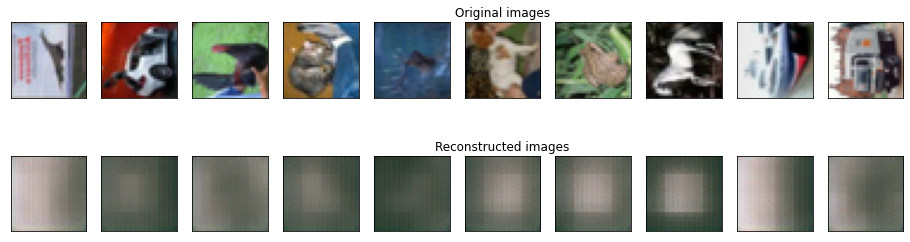


 EPOCH 2/300 	 train loss 255.126 	 val loss 254.446

 EPOCH 3/300 	 train loss 249.935 	 val loss 251.393

 EPOCH 4/300 	 train loss 244.842 	 val loss 242.663

 EPOCH 5/300 	 train loss 238.023 	 val loss 241.344

 EPOCH 6/300 	 train loss 233.698 	 val loss 232.222

 EPOCH 7/300 	 train loss 229.236 	 val loss 228.544

 EPOCH 8/300 	 train loss 227.121 	 val loss 234.314

 EPOCH 9/300 	 train loss 226.574 	 val loss 225.587

 EPOCH 10/300 	 train loss 224.673 	 val loss 224.825

 EPOCH 11/300 	 train loss 223.913 	 val loss 224.271


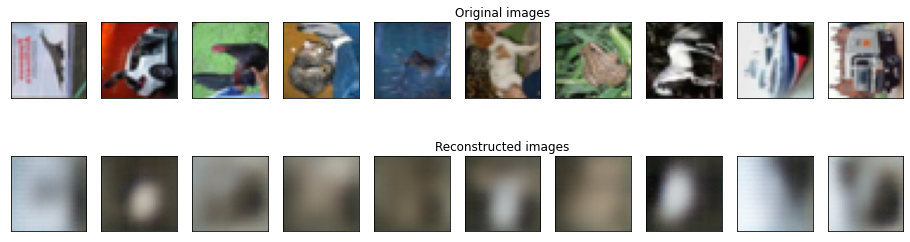


 EPOCH 12/300 	 train loss 222.804 	 val loss 223.371

 EPOCH 13/300 	 train loss 221.941 	 val loss 221.394

 EPOCH 14/300 	 train loss 219.579 	 val loss 219.276

 EPOCH 15/300 	 train loss 218.371 	 val loss 219.754

 EPOCH 16/300 	 train loss 218.095 	 val loss 218.606

 EPOCH 17/300 	 train loss 217.409 	 val loss 218.166

 EPOCH 18/300 	 train loss 216.924 	 val loss 216.965

 EPOCH 19/300 	 train loss 216.443 	 val loss 217.152

 EPOCH 20/300 	 train loss 215.924 	 val loss 216.483

 EPOCH 21/300 	 train loss 215.422 	 val loss 215.841


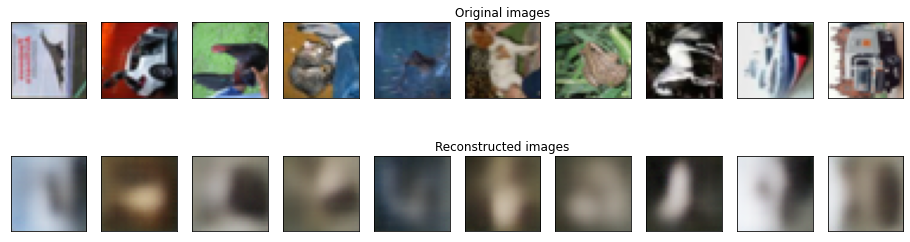


 EPOCH 22/300 	 train loss 214.879 	 val loss 216.127

 EPOCH 23/300 	 train loss 214.887 	 val loss 215.477

 EPOCH 24/300 	 train loss 214.167 	 val loss 214.598

 EPOCH 25/300 	 train loss 213.737 	 val loss 216.053

 EPOCH 26/300 	 train loss 213.354 	 val loss 214.246

 EPOCH 27/300 	 train loss 213.007 	 val loss 213.750

 EPOCH 28/300 	 train loss 212.849 	 val loss 214.977

 EPOCH 29/300 	 train loss 212.689 	 val loss 213.097

 EPOCH 30/300 	 train loss 212.481 	 val loss 213.369

 EPOCH 31/300 	 train loss 212.358 	 val loss 212.927


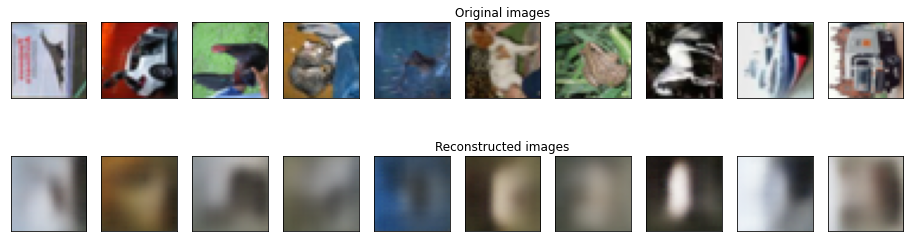


 EPOCH 32/300 	 train loss 212.179 	 val loss 213.551

 EPOCH 33/300 	 train loss 212.111 	 val loss 213.527

 EPOCH 34/300 	 train loss 212.009 	 val loss 212.659

 EPOCH 35/300 	 train loss 211.816 	 val loss 212.442

 EPOCH 36/300 	 train loss 211.603 	 val loss 212.175

 EPOCH 37/300 	 train loss 211.591 	 val loss 211.984

 EPOCH 38/300 	 train loss 211.234 	 val loss 211.914

 EPOCH 39/300 	 train loss 210.982 	 val loss 211.398

 EPOCH 40/300 	 train loss 210.969 	 val loss 211.464

 EPOCH 41/300 	 train loss 210.824 	 val loss 213.339


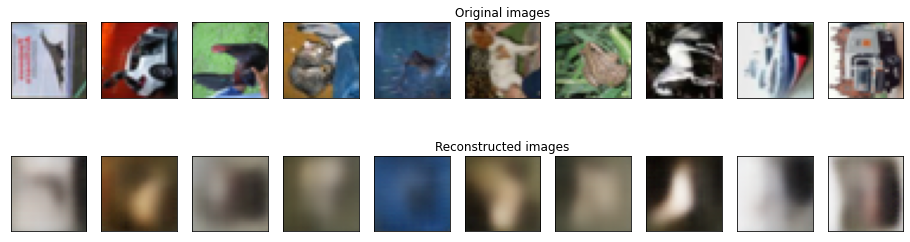


 EPOCH 42/300 	 train loss 210.865 	 val loss 211.421

 EPOCH 43/300 	 train loss 210.728 	 val loss 211.180

 EPOCH 44/300 	 train loss 210.606 	 val loss 211.419

 EPOCH 45/300 	 train loss 210.523 	 val loss 212.047

 EPOCH 46/300 	 train loss 210.390 	 val loss 212.210

 EPOCH 47/300 	 train loss 210.322 	 val loss 210.907

 EPOCH 48/300 	 train loss 210.226 	 val loss 212.472

 EPOCH 49/300 	 train loss 210.186 	 val loss 211.021

 EPOCH 50/300 	 train loss 210.132 	 val loss 210.560

 EPOCH 51/300 	 train loss 210.019 	 val loss 210.408


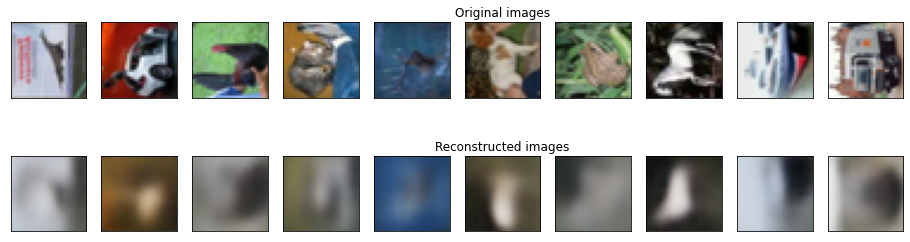


 EPOCH 52/300 	 train loss 210.018 	 val loss 210.723

 EPOCH 53/300 	 train loss 210.039 	 val loss 211.411

 EPOCH 54/300 	 train loss 210.072 	 val loss 210.462

 EPOCH 55/300 	 train loss 209.855 	 val loss 210.456

 EPOCH 56/300 	 train loss 209.789 	 val loss 210.880

 EPOCH 57/300 	 train loss 209.849 	 val loss 210.921

 EPOCH 58/300 	 train loss 209.755 	 val loss 210.523

 EPOCH 59/300 	 train loss 209.761 	 val loss 210.263

 EPOCH 60/300 	 train loss 209.660 	 val loss 210.538

 EPOCH 61/300 	 train loss 209.540 	 val loss 210.728


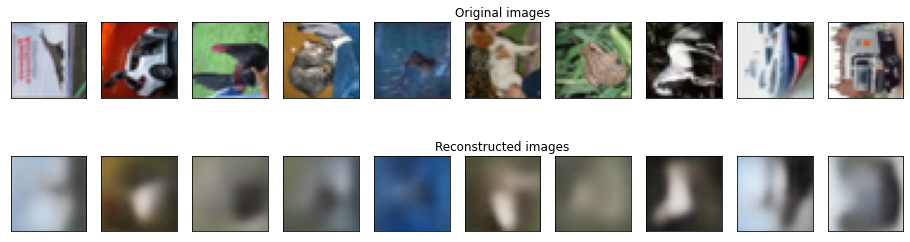


 EPOCH 62/300 	 train loss 209.482 	 val loss 210.432

 EPOCH 63/300 	 train loss 209.387 	 val loss 210.051

 EPOCH 64/300 	 train loss 209.299 	 val loss 210.027

 EPOCH 65/300 	 train loss 209.306 	 val loss 210.333

 EPOCH 66/300 	 train loss 209.294 	 val loss 210.124

 EPOCH 67/300 	 train loss 209.207 	 val loss 211.534

 EPOCH 68/300 	 train loss 209.393 	 val loss 210.269

 EPOCH 69/300 	 train loss 209.160 	 val loss 209.986

 EPOCH 70/300 	 train loss 209.054 	 val loss 210.613

 EPOCH 71/300 	 train loss 209.091 	 val loss 209.562


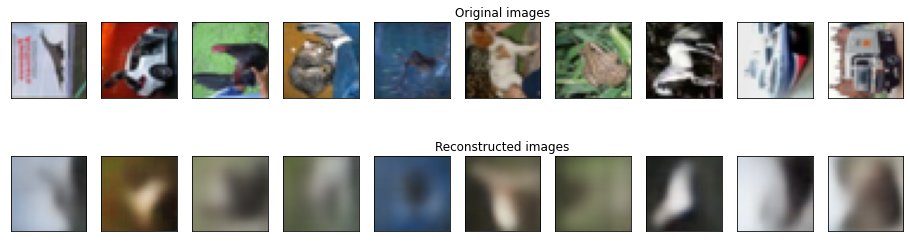


 EPOCH 72/300 	 train loss 209.012 	 val loss 210.307

 EPOCH 73/300 	 train loss 209.069 	 val loss 209.834

 EPOCH 74/300 	 train loss 208.995 	 val loss 210.991

 EPOCH 75/300 	 train loss 209.094 	 val loss 210.074

 EPOCH 76/300 	 train loss 208.977 	 val loss 209.635

 EPOCH 77/300 	 train loss 208.880 	 val loss 209.779

 EPOCH 78/300 	 train loss 208.832 	 val loss 209.634

 EPOCH 79/300 	 train loss 208.825 	 val loss 209.690

 EPOCH 80/300 	 train loss 208.838 	 val loss 209.821



 EPOCH 81/300 	 train loss 208.762 	 val loss 209.489


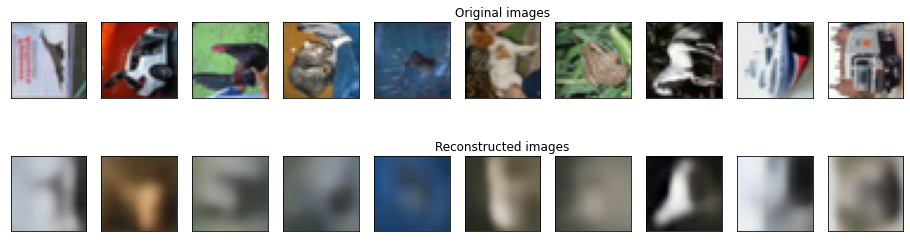


 EPOCH 82/300 	 train loss 208.803 	 val loss 210.085

 EPOCH 83/300 	 train loss 208.683 	 val loss 210.087

 EPOCH 84/300 	 train loss 208.705 	 val loss 209.365

 EPOCH 85/300 	 train loss 208.665 	 val loss 209.708

 EPOCH 86/300 	 train loss 208.604 	 val loss 211.525

 EPOCH 87/300 	 train loss 208.663 	 val loss 209.459

 EPOCH 88/300 	 train loss 208.522 	 val loss 210.565

 EPOCH 89/300 	 train loss 208.538 	 val loss 209.225

 EPOCH 90/300 	 train loss 208.511 	 val loss 209.239

 EPOCH 91/300 	 train loss 208.552 	 val loss 209.582


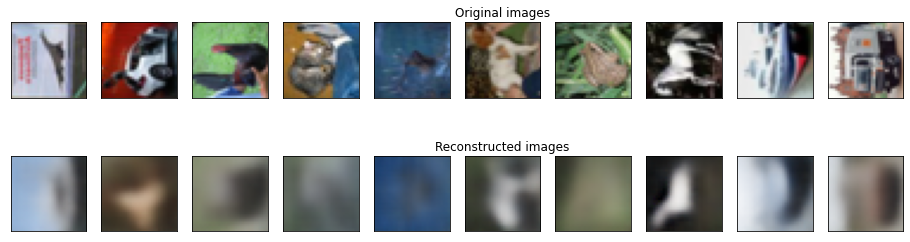


 EPOCH 92/300 	 train loss 208.360 	 val loss 209.203

 EPOCH 93/300 	 train loss 208.444 	 val loss 209.276

 EPOCH 94/300 	 train loss 208.373 	 val loss 209.357

 EPOCH 95/300 	 train loss 208.330 	 val loss 209.654

 EPOCH 96/300 	 train loss 208.289 	 val loss 209.134

 EPOCH 97/300 	 train loss 208.228 	 val loss 209.734

 EPOCH 98/300 	 train loss 208.312 	 val loss 209.194

 EPOCH 99/300 	 train loss 208.169 	 val loss 209.640

 EPOCH 100/300 	 train loss 208.206 	 val loss 208.889

 EPOCH 101/300 	 train loss 208.153 	 val loss 210.875


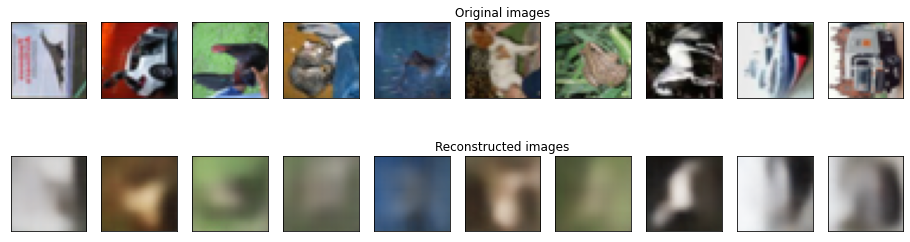


 EPOCH 102/300 	 train loss 208.157 	 val loss 208.833

 EPOCH 103/300 	 train loss 208.048 	 val loss 209.092

 EPOCH 104/300 	 train loss 208.016 	 val loss 209.061

 EPOCH 105/300 	 train loss 207.992 	 val loss 208.872

 EPOCH 106/300 	 train loss 207.936 	 val loss 209.242

 EPOCH 107/300 	 train loss 207.968 	 val loss 209.479

 EPOCH 108/300 	 train loss 207.932 	 val loss 208.744

 EPOCH 109/300 	 train loss 207.859 	 val loss 208.974

 EPOCH 110/300 	 train loss 207.810 	 val loss 208.769

 EPOCH 111/300 	 train loss 207.768 	 val loss 208.546


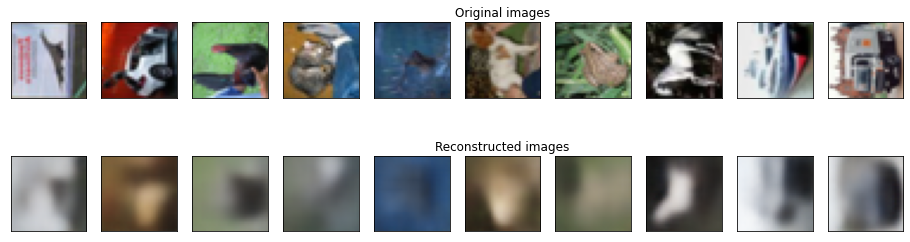


 EPOCH 112/300 	 train loss 207.789 	 val loss 209.144

 EPOCH 113/300 	 train loss 207.886 	 val loss 209.425

 EPOCH 114/300 	 train loss 207.768 	 val loss 208.713

 EPOCH 115/300 	 train loss 207.694 	 val loss 208.910

 EPOCH 116/300 	 train loss 207.782 	 val loss 208.774

 EPOCH 117/300 	 train loss 207.711 	 val loss 209.304

 EPOCH 118/300 	 train loss 207.677 	 val loss 208.919

 EPOCH 119/300 	 train loss 207.670 	 val loss 208.487

 EPOCH 120/300 	 train loss 207.563 	 val loss 209.579

 EPOCH 121/300 	 train loss 207.711 	 val loss 208.735


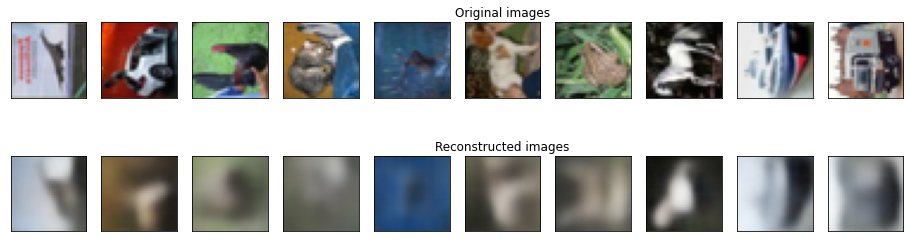


 EPOCH 122/300 	 train loss 207.645 	 val loss 209.931

 EPOCH 123/300 	 train loss 207.726 	 val loss 208.827

 EPOCH 124/300 	 train loss 207.592 	 val loss 209.537

 EPOCH 125/300 	 train loss 207.610 	 val loss 208.477

 EPOCH 126/300 	 train loss 207.544 	 val loss 208.791

 EPOCH 127/300 	 train loss 207.591 	 val loss 209.293

 EPOCH 128/300 	 train loss 207.559 	 val loss 208.624

 EPOCH 129/300 	 train loss 207.557 	 val loss 209.034

 EPOCH 130/300 	 train loss 207.506 	 val loss 208.537

 EPOCH 131/300 	 train loss 207.482 	 val loss 208.966


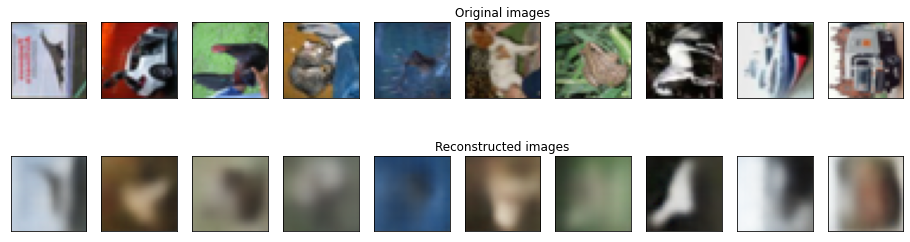


 EPOCH 132/300 	 train loss 207.467 	 val loss 208.802

 EPOCH 133/300 	 train loss 207.460 	 val loss 209.065

 EPOCH 134/300 	 train loss 207.540 	 val loss 208.700

 EPOCH 135/300 	 train loss 207.493 	 val loss 208.666

 EPOCH 136/300 	 train loss 207.400 	 val loss 208.383

 EPOCH 137/300 	 train loss 207.370 	 val loss 208.651

 EPOCH 138/300 	 train loss 207.551 	 val loss 209.010

 EPOCH 139/300 	 train loss 207.419 	 val loss 208.450

 EPOCH 140/300 	 train loss 207.438 	 val loss 210.077

 EPOCH 141/300 	 train loss 207.480 	 val loss 208.578


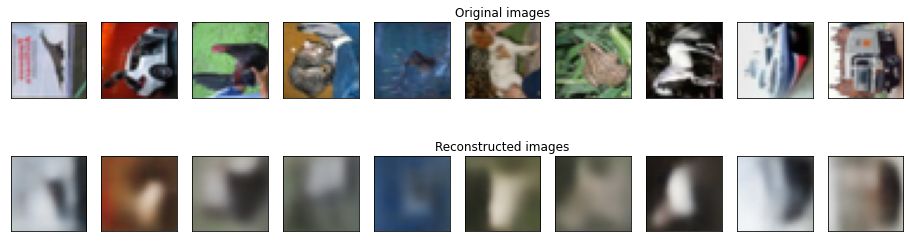


 EPOCH 142/300 	 train loss 207.368 	 val loss 208.516

 EPOCH 143/300 	 train loss 207.321 	 val loss 208.403

 EPOCH 144/300 	 train loss 207.294 	 val loss 209.353

 EPOCH 145/300 	 train loss 207.404 	 val loss 208.278

 EPOCH 146/300 	 train loss 207.395 	 val loss 208.614

 EPOCH 147/300 	 train loss 207.350 	 val loss 208.864

 EPOCH 148/300 	 train loss 207.342 	 val loss 208.739

 EPOCH 149/300 	 train loss 207.333 	 val loss 208.551

 EPOCH 150/300 	 train loss 207.254 	 val loss 208.261

 EPOCH 151/300 	 train loss 207.279 	 val loss 208.682


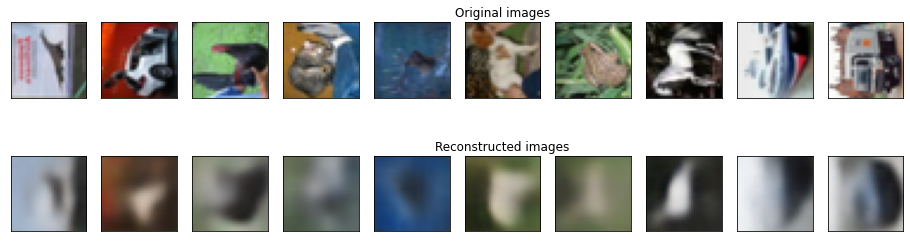


 EPOCH 152/300 	 train loss 207.274 	 val loss 208.837

 EPOCH 153/300 	 train loss 207.249 	 val loss 208.818

 EPOCH 154/300 	 train loss 207.239 	 val loss 208.525

 EPOCH 155/300 	 train loss 207.230 	 val loss 208.290

 EPOCH 156/300 	 train loss 207.238 	 val loss 208.418

 EPOCH 157/300 	 train loss 207.137 	 val loss 208.197

 EPOCH 158/300 	 train loss 207.172 	 val loss 209.220

 EPOCH 159/300 	 train loss 207.206 	 val loss 208.301

 EPOCH 160/300 	 train loss 207.102 	 val loss 208.354

 EPOCH 161/300 	 train loss 207.100 	 val loss 209.042


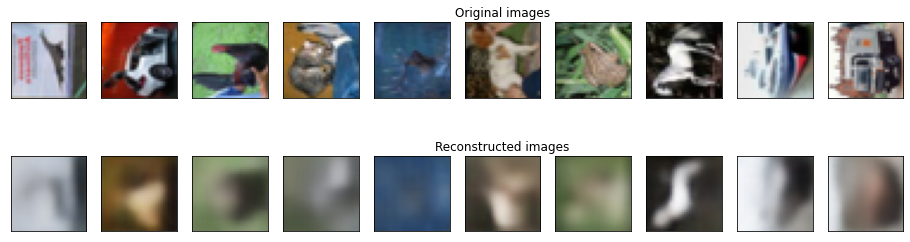


 EPOCH 162/300 	 train loss 207.132 	 val loss 208.156

 EPOCH 163/300 	 train loss 207.103 	 val loss 208.291

 EPOCH 164/300 	 train loss 207.063 	 val loss 208.072

 EPOCH 165/300 	 train loss 207.004 	 val loss 208.373

 EPOCH 166/300 	 train loss 207.151 	 val loss 207.969

 EPOCH 167/300 	 train loss 207.078 	 val loss 210.260

 EPOCH 168/300 	 train loss 207.097 	 val loss 208.014

 EPOCH 169/300 	 train loss 207.050 	 val loss 208.159

 EPOCH 170/300 	 train loss 207.027 	 val loss 208.276

 EPOCH 171/300 	 train loss 206.951 	 val loss 207.917


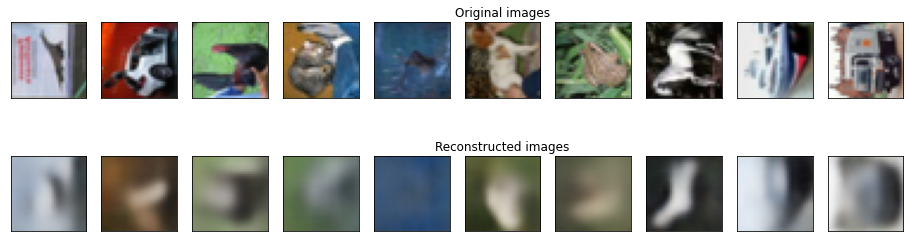


 EPOCH 172/300 	 train loss 207.008 	 val loss 208.262

 EPOCH 173/300 	 train loss 207.060 	 val loss 208.832

 EPOCH 174/300 	 train loss 206.963 	 val loss 208.741

 EPOCH 175/300 	 train loss 206.899 	 val loss 208.211

 EPOCH 176/300 	 train loss 206.926 	 val loss 208.158

 EPOCH 177/300 	 train loss 206.828 	 val loss 208.188

 EPOCH 178/300 	 train loss 206.938 	 val loss 209.189

 EPOCH 179/300 	 train loss 206.996 	 val loss 208.410

 EPOCH 180/300 	 train loss 206.855 	 val loss 207.967

 EPOCH 181/300 	 train loss 206.882 	 val loss 208.607


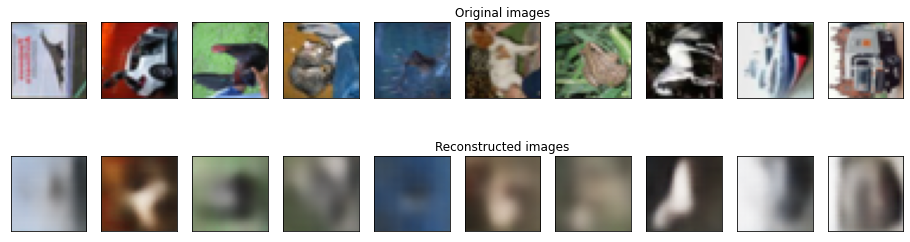


 EPOCH 182/300 	 train loss 206.891 	 val loss 208.121

 EPOCH 183/300 	 train loss 206.809 	 val loss 207.945

 EPOCH 184/300 	 train loss 206.841 	 val loss 208.881

 EPOCH 185/300 	 train loss 206.855 	 val loss 208.062

 EPOCH 186/300 	 train loss 206.837 	 val loss 208.201

 EPOCH 187/300 	 train loss 206.786 	 val loss 208.089

 EPOCH 188/300 	 train loss 206.817 	 val loss 207.804

 EPOCH 189/300 	 train loss 206.795 	 val loss 207.879

 EPOCH 190/300 	 train loss 206.714 	 val loss 207.976

 EPOCH 191/300 	 train loss 206.841 	 val loss 207.958


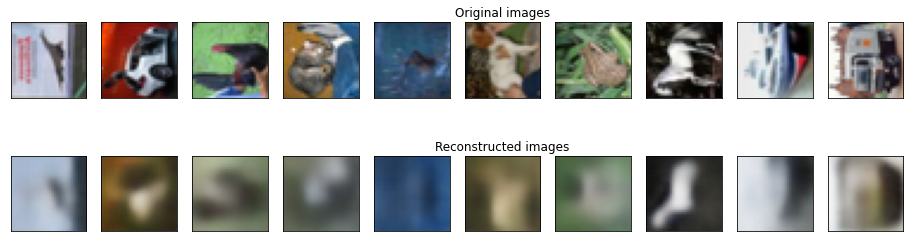


 EPOCH 192/300 	 train loss 206.772 	 val loss 208.282

 EPOCH 193/300 	 train loss 206.759 	 val loss 207.961

 EPOCH 194/300 	 train loss 206.742 	 val loss 208.217

 EPOCH 195/300 	 train loss 206.717 	 val loss 208.381

 EPOCH 196/300 	 train loss 206.766 	 val loss 207.862

 EPOCH 197/300 	 train loss 206.705 	 val loss 207.863

 EPOCH 198/300 	 train loss 206.750 	 val loss 208.194

 EPOCH 199/300 	 train loss 206.723 	 val loss 207.839

 EPOCH 200/300 	 train loss 206.708 	 val loss 208.136

 EPOCH 201/300 	 train loss 206.771 	 val loss 207.855


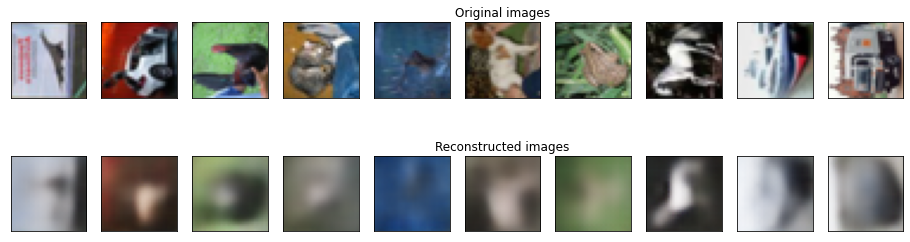


 EPOCH 202/300 	 train loss 206.727 	 val loss 207.872

 EPOCH 203/300 	 train loss 206.745 	 val loss 208.108

 EPOCH 204/300 	 train loss 206.666 	 val loss 207.926

 EPOCH 205/300 	 train loss 206.653 	 val loss 208.456

 EPOCH 206/300 	 train loss 206.737 	 val loss 208.017

 EPOCH 207/300 	 train loss 206.672 	 val loss 208.204

 EPOCH 208/300 	 train loss 206.698 	 val loss 207.739

 EPOCH 209/300 	 train loss 206.679 	 val loss 209.410

 EPOCH 210/300 	 train loss 206.702 	 val loss 208.038

 EPOCH 211/300 	 train loss 206.658 	 val loss 207.831


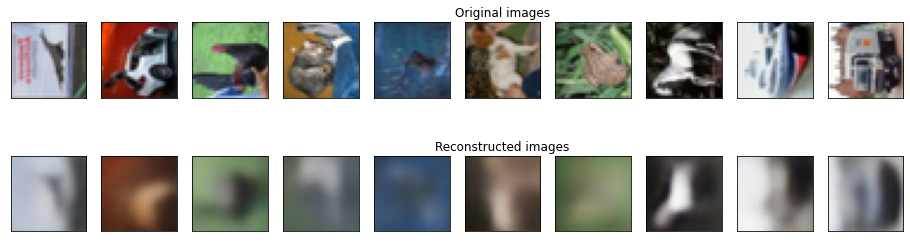


 EPOCH 212/300 	 train loss 206.628 	 val loss 207.973

 EPOCH 213/300 	 train loss 206.661 	 val loss 208.097

 EPOCH 214/300 	 train loss 206.695 	 val loss 208.116

 EPOCH 215/300 	 train loss 206.606 	 val loss 207.848

 EPOCH 216/300 	 train loss 206.603 	 val loss 208.403

 EPOCH 217/300 	 train loss 206.659 	 val loss 208.144

 EPOCH 218/300 	 train loss 206.648 	 val loss 207.957

 EPOCH 219/300 	 train loss 206.548 	 val loss 208.222

 EPOCH 220/300 	 train loss 206.603 	 val loss 207.831

 EPOCH 221/300 	 train loss 206.574 	 val loss 207.904


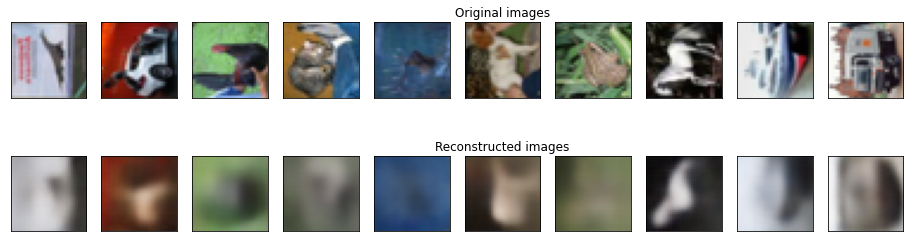


 EPOCH 222/300 	 train loss 206.551 	 val loss 208.233

 EPOCH 223/300 	 train loss 206.631 	 val loss 208.358

 EPOCH 224/300 	 train loss 206.604 	 val loss 207.630

 EPOCH 225/300 	 train loss 206.567 	 val loss 207.888

 EPOCH 226/300 	 train loss 206.528 	 val loss 208.340

 EPOCH 227/300 	 train loss 206.495 	 val loss 208.722

 EPOCH 228/300 	 train loss 206.565 	 val loss 208.380

 EPOCH 229/300 	 train loss 206.565 	 val loss 208.773

 EPOCH 230/300 	 train loss 206.557 	 val loss 207.929

 EPOCH 231/300 	 train loss 206.478 	 val loss 208.834


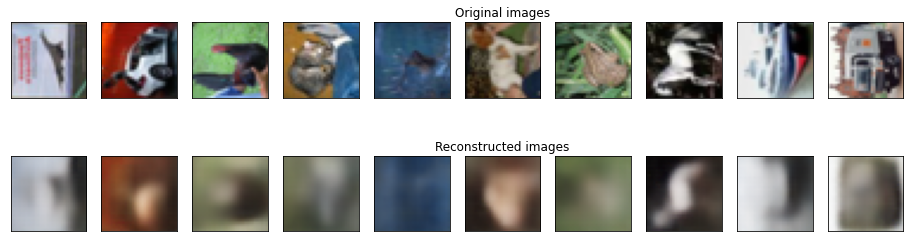


 EPOCH 232/300 	 train loss 206.606 	 val loss 207.833

 EPOCH 233/300 	 train loss 206.502 	 val loss 207.694

 EPOCH 234/300 	 train loss 206.483 	 val loss 208.036

 EPOCH 235/300 	 train loss 206.497 	 val loss 207.733

 EPOCH 236/300 	 train loss 206.540 	 val loss 208.103

 EPOCH 237/300 	 train loss 206.496 	 val loss 207.769

 EPOCH 238/300 	 train loss 206.491 	 val loss 207.760

 EPOCH 239/300 	 train loss 206.493 	 val loss 207.934

 EPOCH 240/300 	 train loss 206.464 	 val loss 207.876

 EPOCH 241/300 	 train loss 206.455 	 val loss 208.160


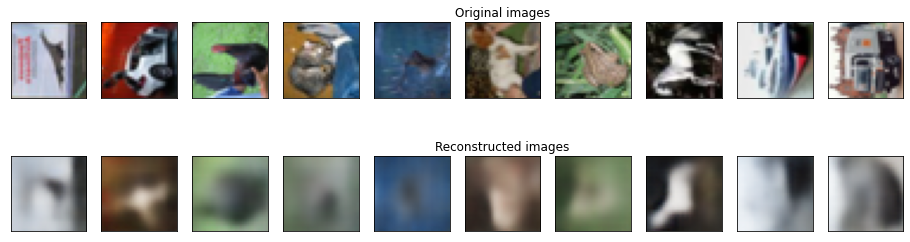


 EPOCH 242/300 	 train loss 206.491 	 val loss 208.342

 EPOCH 243/300 	 train loss 206.494 	 val loss 208.000

 EPOCH 244/300 	 train loss 206.505 	 val loss 207.927

 EPOCH 245/300 	 train loss 206.475 	 val loss 208.093

 EPOCH 246/300 	 train loss 206.397 	 val loss 207.588

 EPOCH 247/300 	 train loss 206.387 	 val loss 208.071

 EPOCH 248/300 	 train loss 206.498 	 val loss 207.942

 EPOCH 249/300 	 train loss 206.367 	 val loss 207.505

 EPOCH 250/300 	 train loss 206.370 	 val loss 208.125

 EPOCH 251/300 	 train loss 206.388 	 val loss 207.911


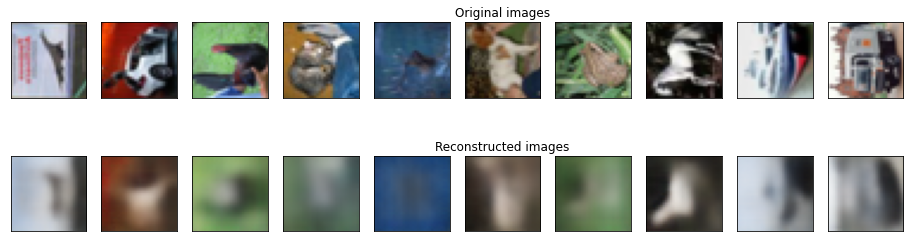


 EPOCH 252/300 	 train loss 206.422 	 val loss 207.727

 EPOCH 253/300 	 train loss 206.404 	 val loss 207.639

 EPOCH 254/300 	 train loss 206.371 	 val loss 207.778

 EPOCH 255/300 	 train loss 206.369 	 val loss 207.662

 EPOCH 256/300 	 train loss 206.377 	 val loss 208.433

 EPOCH 257/300 	 train loss 206.491 	 val loss 207.619

 EPOCH 258/300 	 train loss 206.327 	 val loss 208.915

 EPOCH 259/300 	 train loss 206.341 	 val loss 207.715

 EPOCH 260/300 	 train loss 206.376 	 val loss 208.226

 EPOCH 261/300 	 train loss 206.371 	 val loss 208.051


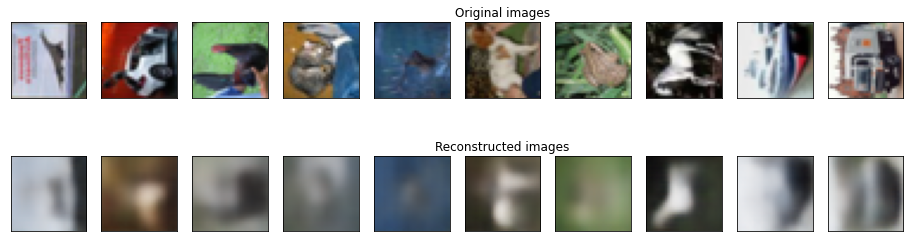


 EPOCH 262/300 	 train loss 206.336 	 val loss 208.715

 EPOCH 263/300 	 train loss 206.422 	 val loss 208.036

 EPOCH 264/300 	 train loss 206.353 	 val loss 207.701

 EPOCH 265/300 	 train loss 206.314 	 val loss 207.870

 EPOCH 266/300 	 train loss 206.235 	 val loss 207.584

 EPOCH 267/300 	 train loss 206.338 	 val loss 207.912

 EPOCH 268/300 	 train loss 206.315 	 val loss 207.580

 EPOCH 269/300 	 train loss 206.294 	 val loss 207.804

 EPOCH 270/300 	 train loss 206.274 	 val loss 208.199

 EPOCH 271/300 	 train loss 206.266 	 val loss 207.522


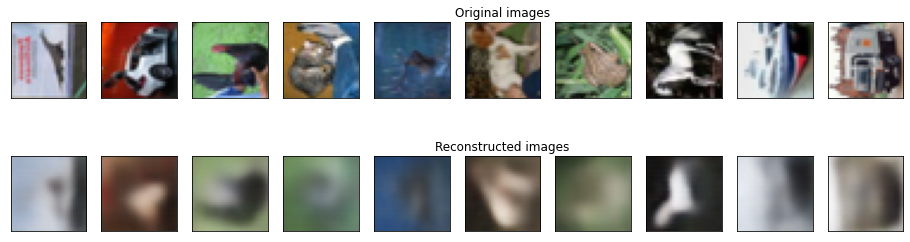


 EPOCH 272/300 	 train loss 206.195 	 val loss 207.601

 EPOCH 273/300 	 train loss 206.159 	 val loss 207.843

 EPOCH 274/300 	 train loss 206.238 	 val loss 208.028

 EPOCH 275/300 	 train loss 206.234 	 val loss 207.622

 EPOCH 276/300 	 train loss 206.267 	 val loss 207.731

 EPOCH 277/300 	 train loss 206.245 	 val loss 207.765

 EPOCH 278/300 	 train loss 206.225 	 val loss 207.672

 EPOCH 279/300 	 train loss 206.244 	 val loss 207.811

 EPOCH 280/300 	 train loss 206.265 	 val loss 207.706

 EPOCH 281/300 	 train loss 206.190 	 val loss 207.594


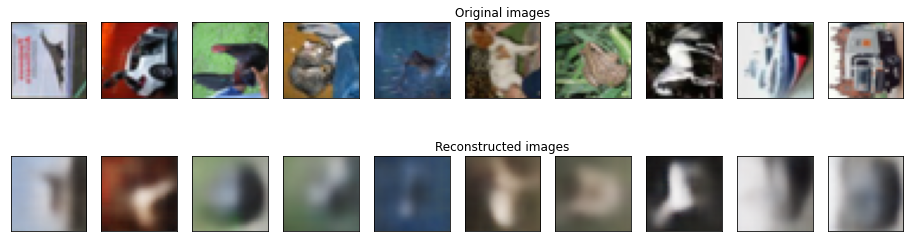


 EPOCH 282/300 	 train loss 206.216 	 val loss 207.495

 EPOCH 283/300 	 train loss 206.162 	 val loss 207.804

 EPOCH 284/300 	 train loss 206.146 	 val loss 207.779

 EPOCH 285/300 	 train loss 206.212 	 val loss 207.687

 EPOCH 286/300 	 train loss 206.151 	 val loss 208.061

 EPOCH 287/300 	 train loss 206.199 	 val loss 208.525

 EPOCH 288/300 	 train loss 206.240 	 val loss 208.686

 EPOCH 289/300 	 train loss 206.230 	 val loss 208.458

 EPOCH 290/300 	 train loss 206.222 	 val loss 207.536

 EPOCH 291/300 	 train loss 206.102 	 val loss 207.835


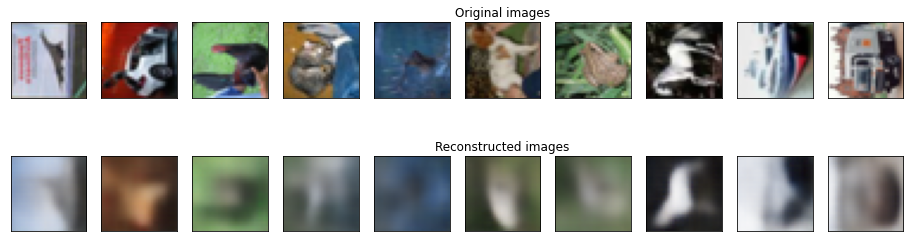


 EPOCH 292/300 	 train loss 206.177 	 val loss 207.858

 EPOCH 293/300 	 train loss 206.170 	 val loss 208.466

 EPOCH 294/300 	 train loss 206.204 	 val loss 207.468

 EPOCH 295/300 	 train loss 206.077 	 val loss 207.795

 EPOCH 296/300 	 train loss 206.122 	 val loss 207.645

 EPOCH 297/300 	 train loss 206.202 	 val loss 207.660

 EPOCH 298/300 	 train loss 206.164 	 val loss 207.861

 EPOCH 299/300 	 train loss 206.149 	 val loss 207.622

 EPOCH 300/300 	 train loss 206.041 	 val loss 207.732


In [ ]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_ae_outputs(vae.encoder,vae.decoder,n=10)

In [ ]:
break

In [ ]:
train_loader

# VAE on Hand-written Dataset 

## Dataset

### Connect to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Datasets/tif'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [ ]:
import os
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt
from statistics import mean
from math import floor

### Custom Dataset Definition

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths,transform=None):
        super(MyDataset, self).__init__()
        self.img_paths = img_paths
        self.transform = transform       

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_name = self.img_paths[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image,'1'

    @property
    def targets(self):
        dummy_targets = ['null']*len(self.img_paths)
        return dummy_targets

### Dataset Loading

In [ ]:
images_paths = [os.path.join(PATH,i) for i in os.listdir(PATH)]
split = 0.85
train_idx = math.floor(split*len(images_paths))
train_images = images_paths[:train_idx]
test_images = images_paths[train_idx:]

### Plotting Few Images

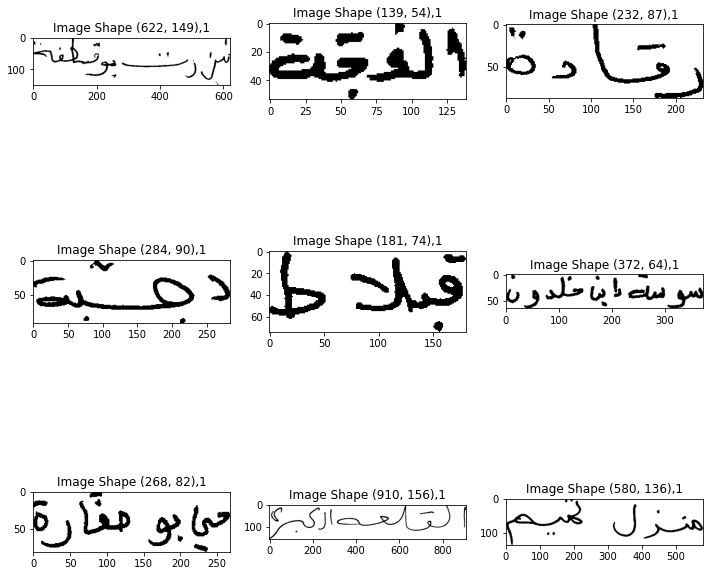

In [ ]:
random_imgs = random.sample(train_images, 9)
random_imgs = [Image.open(i) for i in random_imgs]
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(random_imgs, axs):
    ax.imshow(img)
    ax.title.set_text(f'Image Shape {img.size},{img.mode}')
plt.show()

### Finding Ave Image Dimensions

In [ ]:
h_list = list()
w_list = list()

for p in train_images:
    h_list.append(Image.open(p).size[1])
    w_list.append(Image.open(p).size[0])
num_channels = int(Image.open(p).mode)

h_ave = floor(mean(h_list))
w_ave = floor(mean(w_list))
# resize_size = (h_ave,w_ave)
resize_size = (128,128)

### Dataset Definitions

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(resize_size),])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(resize_size),])

hw_train_dataset = MyDataset(img_paths=train_images,transform=train_transform)
hw_test_dataset = MyDataset(img_paths=test_images,transform=test_transform)

### Dataloader and Batching Definitions

In [ ]:
m=len(hw_train_dataset)


batch_size=8

train_loader = torch.utils.data.DataLoader(hw_train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(hw_test_dataset, batch_size=batch_size)

## Plotting

In [18]:
def plot_ae_custom_ds_outputs(encoder,decoder,test_dataset,n=10):
    wandb_imgs = list()
    wandb_rec_imgs = list()
    my_table = wandb.Table(columns=["Original", "Reconstruction"])
    plt.figure(figsize=(16,4.5))   
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy().T, cmap='gist_gray') # for MNIST remove the transpose
    #   plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray') # for MNIST remove the transpose
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy().T, cmap='gist_gray')  #for MNIST remove the transpose
    #   plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  #for MNIST remove the transpose
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
      my_table.add_data( wandb.Image(img.cpu()), wandb.Image(rec_img.cpu()))
      wandb_imgs.append(img.cpu())
      wandb_rec_imgs.append(rec_img.cpu())
    plt.show()   

## Initialization

### Hyperparameters

In [10]:
base_channel_size = 32
lr = 1e-3
latent_dim = 512
epochs = 300
plot_freq = 10

In [ ]:
hw_train_dataset[0][0].shape

torch.Size([1, 128, 128])

### W&B Init

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

### Initialize VAE

Initialize the VariationalAutoencoder class, the optimizer, and the device to use the GPU in the code.

In [ ]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)
print(vae)

optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
vae.to(device)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=8192, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (linear3): Linear(in_features=256, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=8192, bias=True)
      (3): ReLU(inplace=True)
    )
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=8192, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (linear3): Linear(in_features=256, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=8192, bias=True)
      (3): ReLU(inplace=True)
    )
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3)

## Training

### Train Loop

In [9]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_ae_custom_ds_outputs(vae.encoder,vae.decoder,hw_test_dataset,n=10)

# IAM Dataset


## Dataset

In [22]:
from models.dataset_utils import IAMDataset
from PIL import Image


In [2]:
train_root_dir = '/home/mujahid/PycharmProjects/ssl_wordspotting/datasets/IEHR/words_training'
test_root_dir = '/home/mujahid/PycharmProjects/ssl_wordspotting/datasets/IEHR/words_test'
iam_train_dataset = IAMDataset(train_root_dir)
iam_test_dataset = IAMDataset(test_root_dir)

In [5]:
batch_size=8

train_loader = torch.utils.data.DataLoader(iam_train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(iam_test_dataset, batch_size=batch_size)

In [26]:
h_list = list()
w_list = list()

for p,_ in iam_train_dataset:
    h_list.append(p.size[1])
    w_list.append(p.size[0])
num_channels = 3

h_ave = floor(mean(h_list))
w_ave = floor(mean(w_list))
# resize_size = (h_ave,w_ave)
resize_size = (128,128)

NameError: name 'floor' is not defined

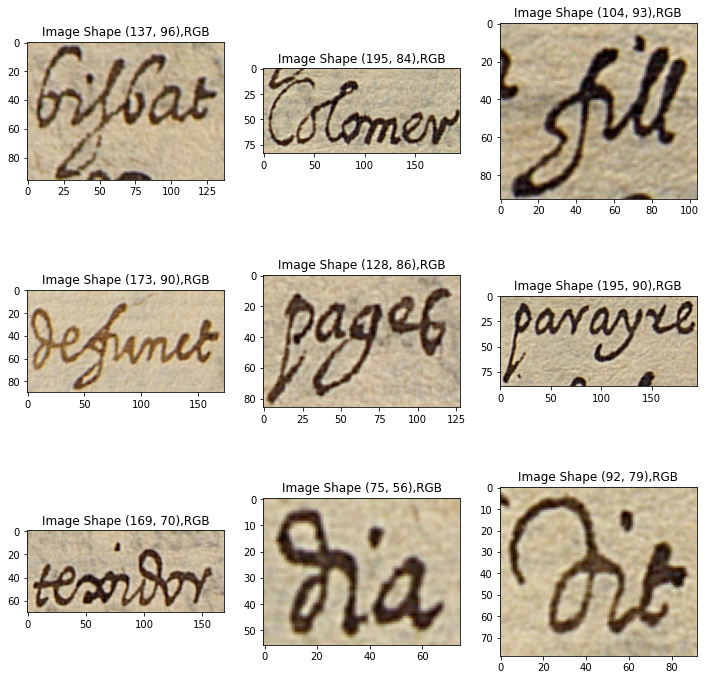

In [8]:
random_imgs = iam_train_dataset.get_random_samples()
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(random_imgs, axs):
    ax.imshow(img)
    ax.title.set_text(f'Image Shape {img.size},{img.mode}')
plt.show()

## Initialization

### HyperParameters

In [9]:
base_channel_size = 32
lr = 1e-3
latent_dim = 512
epochs = 300
plot_freq = 10

### W&B Init

In [10]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Initialize VAE

In [27]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)
print(vae)

optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
vae.to(device)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=8192, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (linear3): Linear(in_features=256, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=8192, bias=True)
      (3): ReLU(inplace=True)
    )
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=8192, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (linear3): Linear(in_features=256, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=8192, bias=True)
      (3): ReLU(inplace=True)
    )
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3)

## Training

### Train Loop

In [28]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_ae_custom_ds_outputs(vae.encoder,vae.decoder,hw_test_dataset,n=10)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.PngImagePlugin.PngImageFile'>